# Probabilistic solvers as collocation methods

Probabilistic solvers condition a prior distribution on satisfying a zero-ODE-residual on a specified grid.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import controls, ivpsolve
from probdiffeq.impl import impl
from probdiffeq.util.doc_util import notebook
from probdiffeq.solvers import uncalibrated, solution
from probdiffeq.solvers.taylor import autodiff
from probdiffeq.solvers.strategies import filters, smoothers, priors, correction

from tueplots import bundles

In [2]:
plt.rcParams.update(notebook.plot_config())
plt.rcParams.update(bundles.neurips2022(nrows=3, ncols=3, family="sans-serif"))

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_platform_name", "cpu")

# Make a solver
impl.select("dense", ode_shape=(1,))

In [3]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.logistic()
t1 = 5.0


@jax.jit
def vector_field(y, t):
    return f(y, *f_args)

In [4]:
NUM_DERIVATIVES = 2
ts = jnp.linspace(t0, t1, endpoint=True)
init_raw, transitions = priors.ibm_discretised(ts, num_derivatives=NUM_DERIVATIVES)

tcoeffs = autodiff.taylor_mode(
    lambda y: vector_field(y, t=t0), (u0[None],), num=NUM_DERIVATIVES
)
init_tcoeffs = impl.ssm_util.normal_from_tcoeffs(
    tcoeffs, num_derivatives=NUM_DERIVATIVES
)


def step(x, cond_and_pre):
    cond, (p, p_inv) = cond_and_pre
    x = impl.ssm_util.preconditioner_apply(x, p_inv)
    extrapolated = impl.conditional.marginalise(x, cond)
    extrapolated = impl.ssm_util.preconditioner_apply(extrapolated, p)
    return extrapolated, extrapolated


_, marg_raw = jax.lax.scan(step, init=init_raw, xs=transitions, reverse=False)
_, marg_tcoeffs = jax.lax.scan(step, init=init_tcoeffs, xs=transitions, reverse=False)

In [5]:
slr1 = correction.ts1()
ibm = priors.ibm_adaptive(num_derivatives=NUM_DERIVATIVES)
solver = uncalibrated.solver(smoothers.smoother_adaptive(ibm, slr1))
sol = ivpsolve.solve_and_save_every_step(
    vector_field,
    tcoeffs,
    t0=t0,
    t1=t1,
    rtol=1e-1,
    dt0=0.1,
    output_scale=1.0,
    solver=solver,
)

In [6]:
eps = 1e-4
mesh = jnp.linspace(t0 + eps, t1 - eps, num=500, endpoint=True)
_, marginals = solution.offgrid_marginals_searchsorted(
    ts=mesh, solution=sol, solver=solver
)

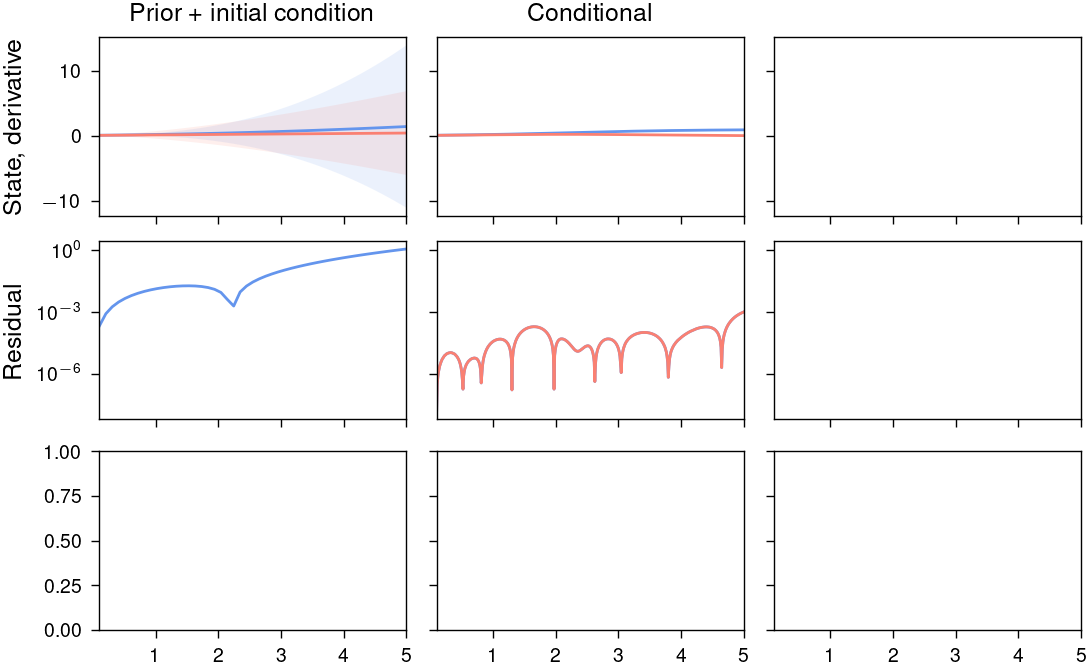

In [10]:
f_vect = jax.vmap(f)
fig, (ax_sol, ax_res, ax_mag) = plt.subplots(
    ncols=3, nrows=3, sharex=True, sharey="row"
)

sol_raw0 = impl.hidden_model.marginal_nth_derivative(marg_raw, 0)
sol_tcoeffs0 = impl.hidden_model.marginal_nth_derivative(marg_tcoeffs, 0)
sol_full0 = impl.hidden_model.marginal_nth_derivative(marginals, 0)

sol_raw1 = impl.hidden_model.marginal_nth_derivative(marg_raw, 1)
sol_tcoeffs1 = impl.hidden_model.marginal_nth_derivative(marg_tcoeffs, 1)
sol_full1 = impl.hidden_model.marginal_nth_derivative(marginals, 1)

# ax_sol[0].set_title("Prior")
# ax_sol[0].set_xlim((ts[1], ts[-1]))
# for sol_raw in (sol_raw0, sol_raw1):
#     m, s = jnp.squeeze(sol_raw.mean), jnp.abs(jnp.squeeze(sol_raw.cholesky))
#     ax_sol[0].plot(ts[1:], m, marker="None")
#     ax_sol[0].fill_between(ts[1:], m - s,m + s, alpha=0.125)

ax_sol[0].set_title(r"Prior + initial condition")
ax_sol[0].set_xlim((ts[1], ts[-1]))
for sol_tcoeffs in (sol_tcoeffs0, sol_tcoeffs1):
    m, s = jnp.squeeze(sol_tcoeffs.mean), jnp.abs(jnp.squeeze(sol_tcoeffs.cholesky))
    ax_sol[0].plot(ts[1:], m, marker="None")
    ax_sol[0].fill_between(ts[1:], m - s, m + s, alpha=0.125)


ax_sol[1].set_title("Conditional")
ax_sol[1].set_xlim((ts[1], ts[-1]))
for sol_full in (sol_full0, sol_full1):
    m, s = jnp.squeeze(sol_full.mean), jnp.abs(jnp.squeeze(sol_full.cholesky))
    ax_sol[1].plot(mesh, m, marker="None")
    ax_sol[1].fill_between(mesh, m - s, m + s, alpha=0.125)

ax_sol[0].set_ylabel("State, derivative")
ax_res[0].set_ylabel("Residual")


# ax_res[0].semilogy(ts[1:], jnp.abs(sol_raw1.mean - jax.vmap(vector_field)(sol_raw0.mean, ts[1:]))+1e-10, marker="None")
ax_res[0].semilogy(
    ts[1:],
    jnp.abs(sol_tcoeffs1.mean - jax.vmap(vector_field)(sol_tcoeffs0.mean, ts[1:]))
    + 1e-10,
    marker="None",
)
ax_res[1].semilogy(
    mesh,
    jnp.abs(sol_full1.mean - jax.vmap(vector_field)(sol_full0.mean, mesh)) + 1e-10,
    marker="None",
)
ax_res[1].semilogy(
    mesh,
    jnp.abs(sol_full1.mean - jax.vmap(vector_field)(sol_full0.mean, mesh)) + 1e-10,
    marker="None",
)

fig.align_ylabels()
plt.savefig("collocation.pdf")

In [8]:
assert False

AssertionError: 

In [ ]:
# Solve the ODE with low precision

In [ ]:
# Evalate the posterior on a dense grid


posterior_u = impl.hidden_model.marginal_nth_derivative(marginals, 0).mean
posterior_du = impl.hidden_model.marginal_nth_derivative(marginals, 1).mean

In [ ]:
# Extrapolate the prior on the dense grid

taylor_coefficients = jnp.reshape(
    sol.marginals.mean[0, ...],
    sol.marginals.target_shape,
    order="F",
)


prior_u = []
prior_du = []
model, _ = filters.filter(*impl)
rv = model.extrapolation.solution_from_tcoeffs(taylor_coefficients)
ssv, extra = model.extrapolation.init(rv)
for t_old, t_new in zip(mesh[:-1], mesh[1:]):
    prior_u.append(rv.marginal_nth_derivative(0).mean)
    prior_du.append(rv.marginal_nth_derivative(1).mean)

    dt = t_new - t_old
    ssv, extra = model.extrapolation.begin(ssv, extra, dt)
    ssv, extra = model.extrapolation.complete(
        ssv, extra, output_scale=sol.output_scale.mean()
    )
    rv = model.extrapolation.extract(ssv, extra)


prior_u.append(rv.marginal_nth_derivative(0).mean)
prior_du.append(rv.marginal_nth_derivative(1).mean)

prior_u = jnp.asarray(prior_u)
prior_du = jnp.asarray(prior_du)

In [ ]:
# Plot the samples

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(5, 3), sharex=True, sharey="row")
((ax0, ax1), (ax2, ax3), (ax4, ax5)) = axes


#######################
ax0.set_ylabel("State")

ax0.set_title("Prior")
ax0.plot(mesh, prior_u, marker="None", label="Estimate")
ax0.plot(
    mesh, posterior_u, marker="None", linestyle="dotted", color="C1", label="Target"
)

ax1.set_title("Posterior")
ax1.plot(mesh, posterior_u, marker="None")
ax1.plot(mesh, posterior_u, marker="None", linestyle="dotted", color="C1")


#######################
ax2.set_ylabel("Residual")

ax2.plot(mesh, prior_du - f_vect(prior_u, *f_args), marker="None")
ax2.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax3.plot(mesh, posterior_du - f_vect(posterior_u, *f_args), marker="None")
ax3.axhline(0.0, linestyle="dotted", color="C1", marker="None")


#######################
ax4.set_ylabel("|| Residual ||")

ax4.semilogy(mesh, jnp.abs(prior_du - f_vect(prior_u, *f_args)), marker="None")
ax5.semilogy(mesh, jnp.abs(posterior_du - f_vect(posterior_u, *f_args)), marker="None")
ax4.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax5.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax4.set_ylim((1e-8, 1e0))
ax5.set_ylim((1e-8, 1e0))


ax0.set_xlim((t0, t1))
ax0.legend()
fig.align_ylabels()
plt.show()

The prior state estimate (top left) has a large residual $\dot u - f(u)$. By conditioning on satisfying a zero residual (bottom left to bottom right), the state estimate becomes a useful ODE solution (top right).